In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import fiona
import os
%matplotlib inline

In [2]:
def abstraction_parser(df_abstraction, save=False, shp_out=''):
    """
    Function to create a geodataframe from a csv file. 
    Locations in the csv file are stored in UTM 37N and are parsed to espg:4326

    Parameters
    ----------
    df_abstraction: pandas.DataFrame
        dataframe containing the abstraction points
    save: boolean [optional]
        if True and a name is defined (shp_out) it will store the geodataframe
        to shapefile
    shp_out: str [optional]
        if save is True it will store the geodataframe
    """
    geometry = [Point(xy)
                for xy in zip(df_abstraction.UTMx, df_abstraction.UTMy)]
    crs = {'init': 'epsg:32637'}
    gdf_abstraction = gpd.GeoDataFrame(
        df_abstraction, crs=crs, geometry=geometry)
    gdf_abstraction['geometry'] = gdf_abstraction['geometry'].to_crs(epsg=4326)
    # gdf_abstraction.dropna(inplace=True)
    gdf_abstraction.crs = from_epsg(4326)
    gdf_abstraction.reset_index(inplace=True)
    gdf_abstraction.loc[:, 'index'] = 'Awash-River'

    if save == True and shp_out is not '':
        # Save to disk
        gdf_abstraction.to_file(shp_out)
        print(shp_out)

    return gdf_abstraction

In [3]:
def abstraction2schematization(gdf_abstraction, save=False, shp_out=''):
    """
    Function to create a schematized polyline from the abstraction points.

    Parameters
    ----------
    gdf_abstraction: geopandas.GeoDataFrame
        geodataframe containing the abstraction points in epsg:4326
    save: boolean [optional]
        if True and a name is defined (shp_out) it will store the geodataframe
        to shapefile
    shp_out: str [optional]
        if save is True it will store the geodataframe
    """
    # Aggregate these points with the GroupBy
    gdf_abstraction_schematized = gdf_abstraction.groupby(
        ['index'])['geometry'].apply(lambda x: LineString(x.tolist()))
    gdf_abstraction_schematized = gpd.GeoDataFrame(data=gdf_abstraction_schematized,
                                                   geometry='geometry',
                                                   crs=gdf_abstraction.crs)

    if save == True and shp_out is not '':
        # Save to disk
        gdf_abstraction_schematized.to_file(shp_out)
        print(shp_out)

    return gdf_abstraction_schematized

In [4]:
def gdf2geojson(gdf, geojson_out):
    """
    Function to create a geojson format for storage on data services portal

    Parameter
    --------
    gdf : geopandas.GeoDataFrame
        geodataframe to be parsed into geojson
    geojson_out : str
        path to store geojson file
    """
    with open(geojson_out, 'w') as f:
        f.write(gdf.to_json())

In [5]:
base_folder = r'D:\Projects\Pr\3348.10\Werkfolder'

json_awash = os.path.join(base_folder, 'json', 'simplified', 'catchment.json')
shp_gauging_stations = os.path.join(
    base_folder, 'shp', 'rivergauging_stations.shp')
json_river = os.path.join(base_folder, 'json', 'simplified', 'river.json')
csv_abstraction_points = os.path.join(
    base_folder, 'csv', 'abstraction_points.csv')

# load basemaps
gdf_awash = gpd.read_file(json_awash, driver='GeoJSON')
gdf_gauge = gpd.read_file(shp_gauging_stations)
gdf_river = gpd.read_file(json_river, driver='GeoJSON')

In [6]:
shp_abs_points = os.path.join(base_folder, 'shp', 'abstraction_points.shp')

# abstraction points
df_abstraction = pd.read_csv(csv_abstraction_points)
gdf_abstraction = abstraction_parser(
    df_abstraction, save=True, shp_out=shp_abs_points)

# schmematize
shp_abs_schema = os.path.join(base_folder, 'shp', 'abstraction_schema.shp')
gdf_abstraction_schematized = abstraction2schematization(
    gdf_abstraction, save=True, shp_out=shp_abs_schema)

D:\Projects\Pr\3348.10\Werkfolder\shp\abstraction_points.shp
D:\Projects\Pr\3348.10\Werkfolder\shp\abstraction_schema.shp


In [7]:
df_abstraction.head()

,index,Abstraction points,UTMx,UTMy,Total crop area (ha),Major crops or aggregates,Diversion system,geometry
0,Awash-River,Area @ koka,517228,936161,800,"Vegetable*, flower",Pump,POINT (39.15651903010993 8.469094151895581)
1,Awash-River,Adama water supply,517441,936147,_,_,Pump,POINT (39.15845411102872 8.468966737645287)
2,Awash-River,Upstream wonjo,519959,937045,400,Vegetable,Pump,POINT (39.18133425107597 8.47707946712004)
3,Awash-River,Wonji main,525506,934781,"5,904",Sugarcane,Pump,POINT (39.23171811821993 8.456574314711492)
4,Awash-River,Kuriftu,531565,930067,"1,123",Sugarcane,Pump,POINT (39.28673134297797 8.413898563738627)


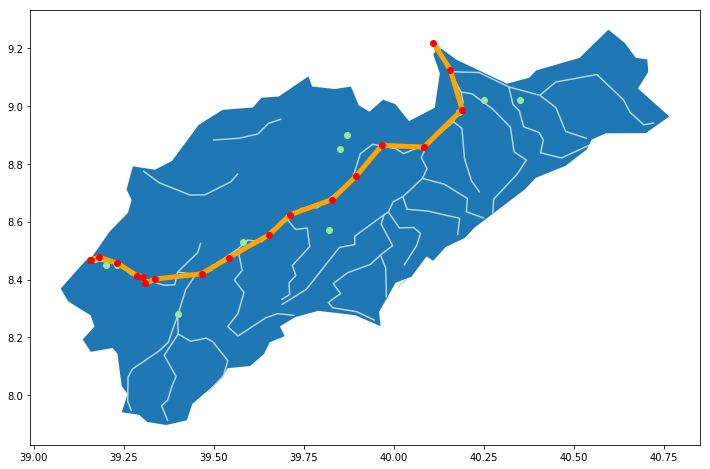

In [8]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
gdf_awash.plot(ax=ax)
gdf_river.plot(ax=ax, color='lightblue')
gdf_abstraction.plot(ax=ax, color='red', zorder=20)
gdf_gauge.plot(ax=ax, color='lightgreen')
gdf_abstraction_schematized.plot(ax=ax, color='orange', linewidth=5)

In [9]:
linestring = gdf_abstraction_schematized['geometry'].iloc[0]

list_name = []
list_geometry = []

for idx, row in gdf_abstraction.iterrows():
    #print(idx, row['Abstraction points'])
    list_name.append(row['Abstraction points'])
    
    try:
        segment = LineString([linestring.coords[idx], linestring.coords[idx+1]])
        list_geometry.append(segment)
    except IndexError as e:
        pass

In [10]:
df_segments = pd.DataFrame([list_name,list_geometry]).T
df_segments.columns = ['name','geometry']
gdf_segments = gpd.GeoDataFrame(data=df_segments, geometry='geometry', crs=gdf_abstraction.crs)

In [11]:
gdf_segments.head()

,name,geometry
0,Area @ koka,LINESTRING (39.15651903010993 8.46909415189558...
1,Adama water supply,LINESTRING (39.15845411102872 8.46896673764528...
2,Upstream wonjo,LINESTRING (39.18133425107597 8.47707946712004...
3,Wonji main,LINESTRING (39.23171811821993 8.45657431471149...
4,Kuriftu,LINESTRING (39.28673134297797 8.41389856373862...


In [47]:
gdf_segments.drop(index=18, inplace=True)

In [53]:
gdf_segments['geometry'].to_crs(epsg=32637).length.sum()

172563.19964044189

In [60]:
gdf_segments.index = gdf_segments.index[::-1]

In [61]:
gdf_list = [gdf_awash, gdf_river, gdf_abstraction,
            gdf_gauge, gdf_abstraction_schematized, gdf_segments]
gdf_name = ['catchment', 'river', 'abstraction_points',
            'gauge_points', 'abstraction_schematized', 'segments']

# store the geopandas geodataframe into geojson
for idx in range(len(gdf_name)):
    gdf = gdf_list[idx]
    geojson_name = gdf_name[idx]
    geojson_out = os.path.join(
        base_folder, 'json', '{}.json'.format(geojson_name))
    gdf2geojson(gdf, geojson_out)

In [14]:
from hkvportal.io.services import dataportal as dp
dp = dp()
dp.setDataservice(dataservice='https://data.hkvservices.nl/dataservices/')

dataservice is set. https://data.hkvservices.nl/dataservices/ will be used as portal


In [ ]:
dp.listDatabase(database='Ethiopia')

In [18]:
import json
vega_spec_path = os.path.join(base_folder, 'json', 'river.json')
vega_spec = json.load(open(vega_spec_path))
# json data uploaden naar data portal
dp.setEntryDatabase(database = 'Ethiopia', key = 'geojson_river', data = json.dumps(vega_spec), description = 'Awash Awash basin rivers')

{'date': '2017-12-20 19:23:15',
 'id': 'a2839933-b647-42af-97c3-8c8d26fb6758',
 'key': 'geojson_river'}

In [19]:
vega_spec_path = os.path.join(base_folder, 'json', 'catchment.json')
vega_spec = json.load(open(vega_spec_path))
# json data uploaden naar data portal
dp.setEntryDatabase(database = 'Ethiopia', key = 'geojson_catchment', data = json.dumps(vega_spec), description = 'Awash Awash basin catchment')

{'date': '2017-12-20 19:23:29',
 'id': '23303693-03ec-4964-a6a8-4e8b557f012c',
 'key': 'geojson_catchment'}

In [62]:
vega_spec_path = os.path.join(base_folder, 'json', 'segments.json')
vega_spec = json.load(open(vega_spec_path))
# json data uploaden naar data portal
dp.setEntryDatabase(database = 'Ethiopia', key = 'geojson_segments', data = json.dumps(vega_spec), description = 'Awash Awash diversion points schematized')

{'date': '2017-12-20 20:59:03',
 'id': 'da466ba7-87b1-44ad-a306-080ee66ab05d',
 'key': 'geojson_segments'}

In [54]:
vega_spec_path = os.path.join(base_folder, 'json', 'abstraction_points.json')
vega_spec = json.load(open(vega_spec_path))
# json data uploaden naar data portal
dp.setEntryDatabase(database = 'Ethiopia', key = 'geojson_diversion_locations', data = json.dumps(vega_spec), description = 'Awash Awash diversion points')

{'date': '2017-12-20 20:02:29',
 'id': '9ee82677-bdee-44a6-9288-44cb6408369f',
 'key': 'geojson_diversion_locations'}

In [64]:
vega_spec_path = os.path.join(base_folder, 'json', 'vega3_map.json')
vega_spec = json.load(open(vega_spec_path))
# json data uploaden naar data portal
dp.setEntryDatabase(database = 'Ethiopia', key = 'vega3_map', data = json.dumps(vega_spec), description = 'Vega-3 map specification')

{'date': '2017-12-20 21:12:49',
 'id': '76ebcb20-1596-4ea4-be9c-29d06bd1ca2e',
 'key': 'vega3_map'}